### [Image Patch Extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#image-feature-extraction)

- [extract_patches_2d](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.image.extract_patches_2d.html#sklearn.feature_extraction.image.extract_patches_2d) returns patches from an image stored as a 2D array, or 3D with color information along the third axis.

- [reconstruct_from_patches_2d](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.image.reconstruct_from_patches_2d.html#sklearn.feature_extraction.image.reconstruct_from_patches_2d) rebuilds the image.

- Below: generate 4x4 pixel picture with 3 color channels.

In [2]:
import numpy as np
from sklearn.feature_extraction import image

one_image = np.arange(4 * 4 * 3).reshape((4, 4, 3))
print(one_image[:, :, 0],"\n")  # R channel of a fake RGB picture

patches = image.extract_patches_2d(one_image, 
                                   (2, 2), 
                                   max_patches=2,
                                   random_state=0)

print(patches.shape,"\n")
print(patches[:, :, :, 0],"\n")

patches = image.extract_patches_2d(one_image, 
                                   (2, 2))
print(patches.shape,"\n")
print(patches[4, :, :, 0],"\n")

[[ 0  3  6  9]
 [12 15 18 21]
 [24 27 30 33]
 [36 39 42 45]] 

(2, 2, 2, 3) 

[[[ 0  3]
  [12 15]]

 [[15 18]
  [27 30]]] 

(9, 2, 2, 3) 

[[15 18]
 [27 30]] 



- Now try to reconstruct the original image from the patches - by averaging on non-overlapping areas.

In [3]:
reconstructed = image.reconstruct_from_patches_2d(patches, 
                                                  (4, 4, 3))

np.testing.assert_array_equal(one_image, 
                              reconstructed)

- [PatchExtractor](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.image.PatchExtractor.html#sklearn.feature_extraction.image.PatchExtractor) works the same way as [extract_patches_2d](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.image.extract_patches_2d.html#sklearn.feature_extraction.image.extract_patches_2d) and supports multiple images.

- It is an estimator & can be used in a pipeline.

In [4]:
five_images = np.arange(5 * 4 * 4 * 3).reshape(5, 4, 4, 3)
patches = image.PatchExtractor(patch_size=(2, 2)).transform(five_images)
patches.shape

(45, 2, 2, 3)

### Connectivity Graphs

- [img_to_graph](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.image.img_to_graph.html#sklearn.feature_extraction.image.img_to_graph) returns a connectivity matrix from a 2D or 3D image.

- [grid_to_graph](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.image.grid_to_graph.html#sklearn.feature_extraction.image.grid_to_graph) returns a connectivity matrix for images given the shape of the images.

### [Example: Ward hierarchical clustering on coin images](https://scikit-learn.org/stable/auto_examples/cluster/plot_coin_ward_segmentation.html#sphx-glr-auto-examples-cluster-plot-coin-ward-segmentation-py)

- 

In [5]:
import time as time
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import skimage
from skimage.data import coins
from skimage.transform import rescale
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering
from sklearn.utils.fixes import parse_version

In [6]:
# these were introduced in skimage-0.14
if parse_version(skimage.__version__) >= parse_version('0.14'):
    rescale_params = {'anti_aliasing': False, 'multichannel': False}
else:
    rescale_params = {}

In [7]:
# Generate data
# Resize to 20% of original size to speed up the processing
# Apply a Gaussian filter for smoothing prior to down-scaling
# reduces aliasing artifacts.

orig_coins       = coins()
smoothened_coins = gaussian_filter(orig_coins, sigma=2)
rescaled_coins   = rescale(smoothened_coins, 0.2, 
                           mode="reflect",
                           **rescale_params)

X = np.reshape(rescaled_coins, (-1, 1))
print(X.shape)

(4697, 1)


In [8]:
# Define the structure A of the data. Pixels connected to their neighbors.
connectivity = grid_to_graph(*rescaled_coins.shape)

In [9]:
st = time.time()
n_clusters = 27  # number of regions
ward = AgglomerativeClustering(n_clusters   = n_clusters, 
                               linkage      = 'ward',
                               connectivity = connectivity)
ward.fit(X)
label = np.reshape(ward.labels_, 
                   rescaled_coins.shape)

print("Elapsed time: ", time.time() - st)
print("Number of pixels\t: ", label.size)
print("Number of clusters\t: ", np.unique(label).size)

Elapsed time:  0.16572237014770508
Number of pixels	:  4697
Number of clusters	:  27


([], [])

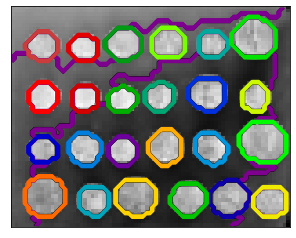

In [10]:
# Plot the results on an image
plt.figure(figsize=(5, 5))
plt.imshow(rescaled_coins, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(label == l,
                colors=[plt.cm.nipy_spectral(l / float(n_clusters)), ])
plt.xticks(())
plt.yticks(())